In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, make_scorer
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import tree
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier, Booster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import plotly.express as px

sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('/content/tripadvisor_hotel_reviews.csv')

# Exploratory Data Analysis

In [3]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
df.isna().sum()

,0
Review,0
Rating,0


**Review Count Visual**

<ipython-input-5-98a7ef819387>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = grouped.index, y = grouped.values, palette='mako').set_title('Review Count by Rating')


Text(0.5, 1.0, 'Review Count by Rating')

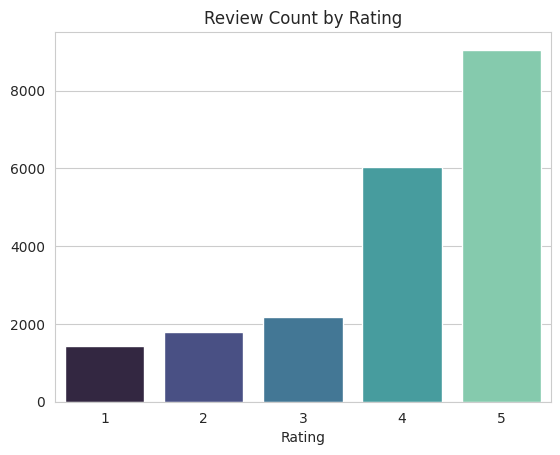

In [5]:
grouped = df.groupby('Rating')['Rating'].count()
sns.barplot(x = grouped.index, y = grouped.values, palette='mako').set_title('Review Count by Rating')

After plotting review count per rating, it is evident that there is a class imbalance. By group together ratings of 1 and 2, ratings of 3 and 4, and rating 5, the class imbalance should be reduced.

In [6]:
def new_rating(num):
    if (num == 1) or (num == 2):
        return 'poor'
    elif (num == 3) or (num == 4):
        return 'average'
    else:
        return 'excellent'

df['new_rating'] = df['Rating'].apply(new_rating)

<ipython-input-7-2738a58cb12d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = ['poor','average','excellent'], y = [3214, 8223, 9054], palette='mako').set_title('Grouped Review Count by Rating')


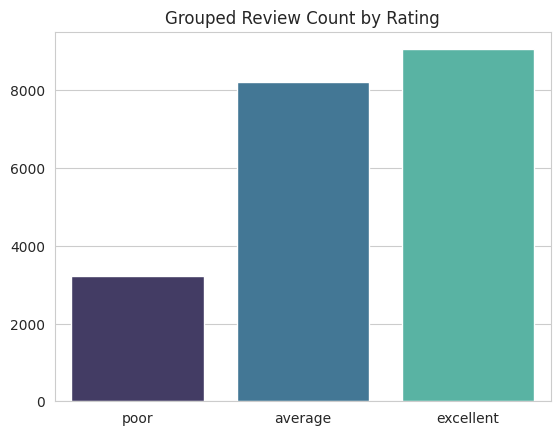

In [7]:
new_rating_grouped = df.groupby('new_rating')['Rating'].count()
new_rating_grouped
ax = sns.barplot(x = ['poor','average','excellent'], y = [3214, 8223, 9054], palette='mako').set_title('Grouped Review Count by Rating')

The class imbalance is less prominent now, but there are still less "poor" review types. This will be accounted for by using the class_weight="balanced" parameter in the models.

**Word Count Graph**

Text(0.5, 1.0, 'Word Count by Review')

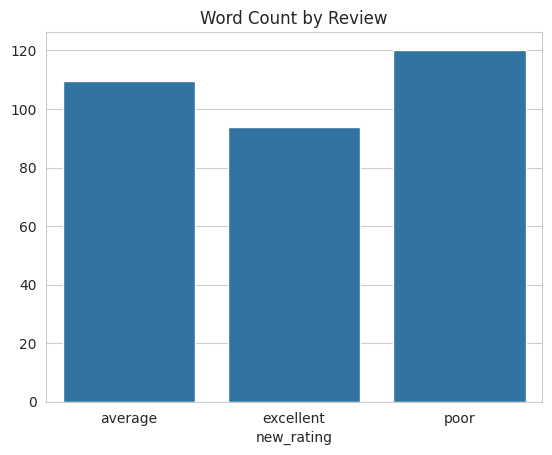

In [8]:
df['words'] = [x.split() for x in df['Review']]
df['word_count'] = [len(x) for x in df['words']]

grouped_rating = df.groupby('new_rating')['word_count'].mean()
sns.barplot(x = grouped_rating.index, y = grouped_rating.values).set_title('Word Count by Review')

This graph shows that the larger the word count, the worse the review. It is worth considering including this feature in the modeling process.

# Preprocessing

Functions will be used on the "Reviews" column in order to prepare the data for modeling.

In [10]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
sw = stopwords.words('english')

In [22]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize tools
tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:’[a-z]+)?")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Process text data
df['Review'] = df['Review'].astype(str)  # Ensure all reviews are strings
df['Review'] = df['Review'].str.lower()  # Convert to lowercase
df['tokens'] = df['Review'].apply(lambda x: tokenizer.tokenize(x))  # Tokenization
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])  # Remove stopwords
df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])  # Lemmatization

# Join tokens back into a sentence
df['tokenized'] = df['tokens'].apply(lambda x: ' '.join(x))

# Display result
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Review,Rating,new_rating,words,word_count,tokens,tokenized
0,nice hotel expensive parking got good deal sta...,4,average,"[nice, hotel, expensive, parking, got, good, d...",87,"[nice, hotel, expensive, parking, got, good, d...",nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,poor,"[ok, nothing, special, charge, diamond, member...",250,"[ok, nothing, special, charge, diamond, member...",ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,average,"[nice, rooms, not, 4*, experience, hotel, mona...",217,"[nice, room, experience, hotel, monaco, seattl...",nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,excellent,"[unique,, great, stay,, wonderful, time, hotel...",89,"[unique, great, stay, wonderful, time, hotel, ...",unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,excellent,"[great, stay, great, stay,, went, seahawk, gam...",191,"[great, stay, great, stay, went, seahawk, game...",great stay great stay went seahawk game awesom...


<Axes: xlabel='Samples', ylabel='Counts'>

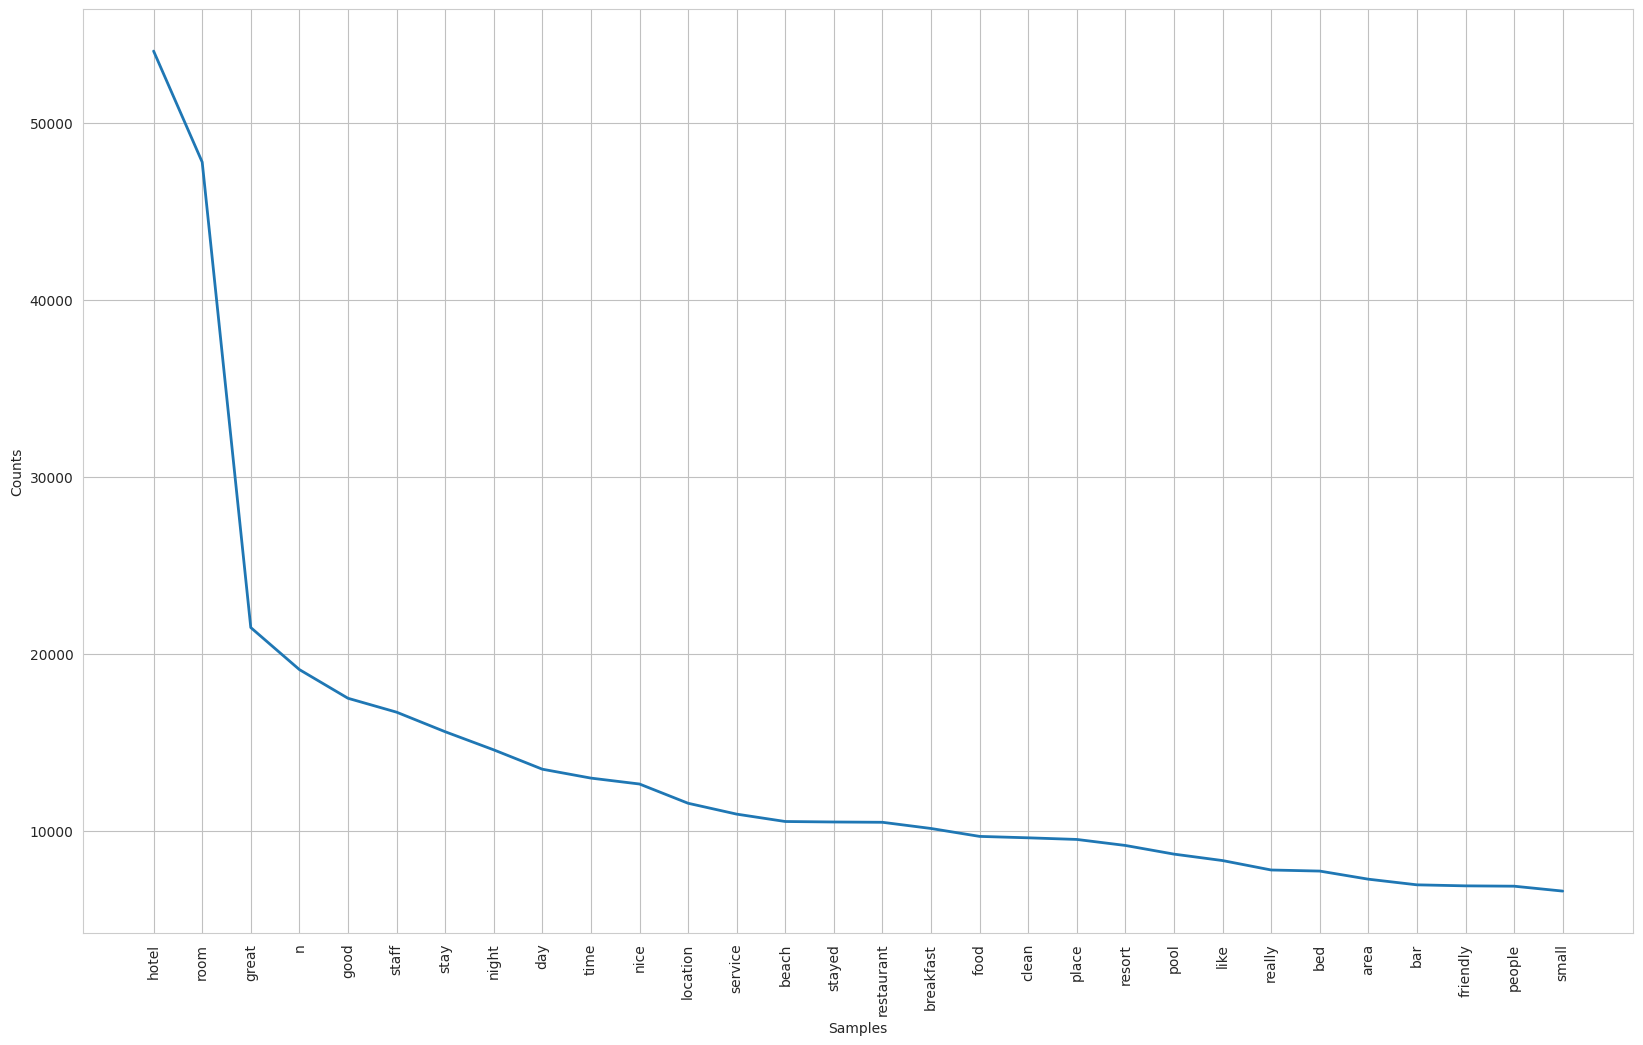

In [23]:
df['tokenized_words'] = [x.split() for x in df['tokenized']]
tokenized_words = df['tokenized_words'].to_list()

word_list = []
for x in tokenized_words:
    word_list.extend(x)
word_list
freq_dist_text = nltk.FreqDist(word_list)
plt.subplots(figsize=(20,12))
freq_dist_text.plot(30)

This frequency distribution shows which words have a higher frequency in the corpus.

In [24]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

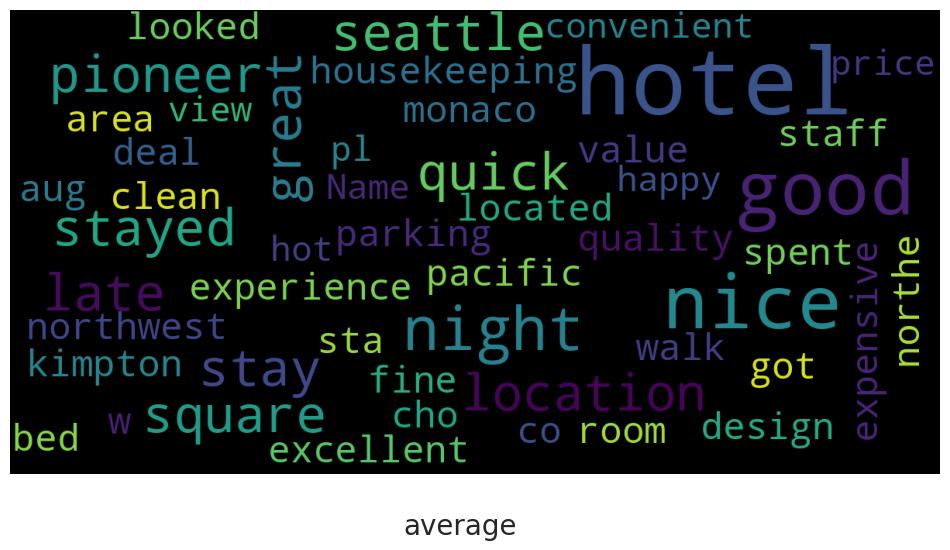

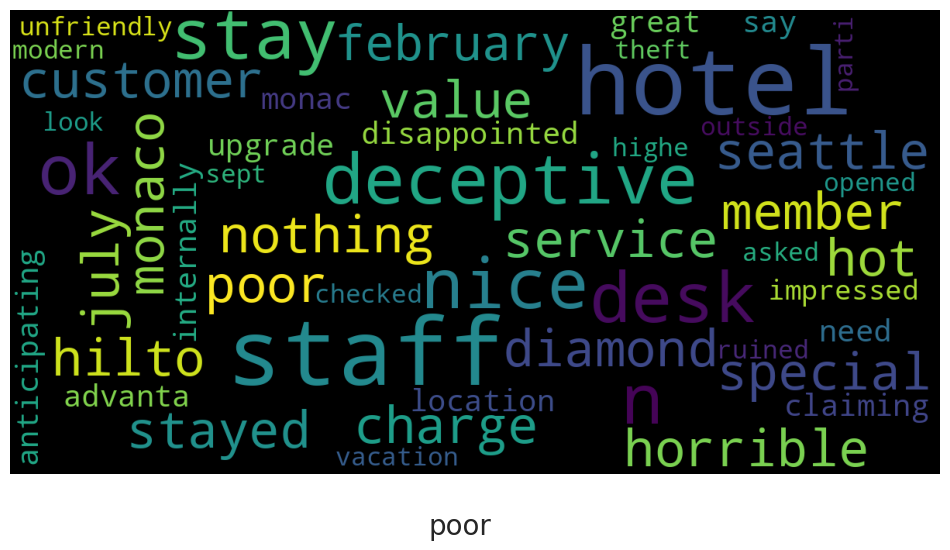

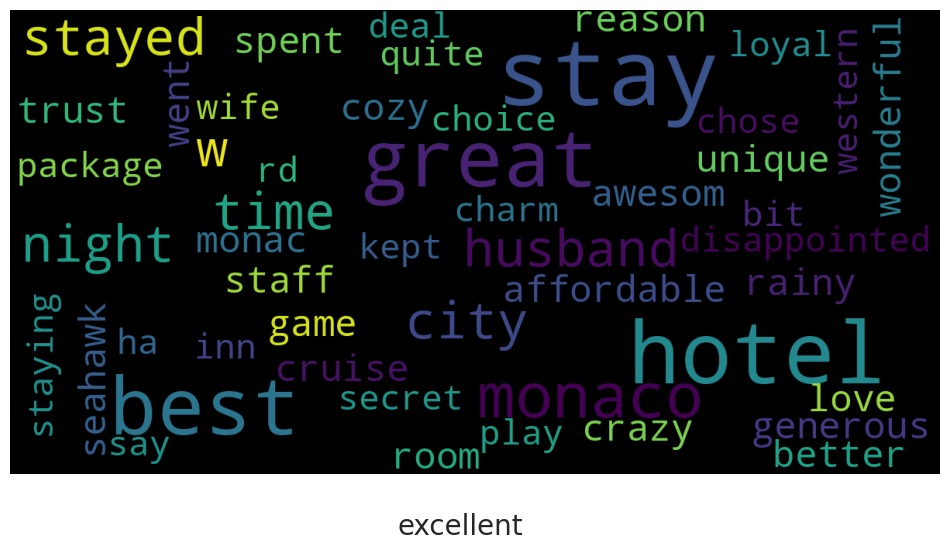

In [25]:
for rating in list(df['new_rating'].unique()):
    show_wordcloud(df[df['new_rating']==rating]['tokenized'], title=rating)

The word clouds above show which words appear most frequently in each category.

**Part of Speech Violin Plot**

In [30]:
df_eda = pd.DataFrame()
df_eda['LEM']  = df.tokenized
#df_eda['POS']  = df.tokenized.apply(lambda x: [pos_tag[1] for pos_tag in pos_tag(x)])     #<---pos-tagged tokens ("bag of tags")
'''df_eda['NOUN'] = df_eda.POS.apply(
    lambda x: sum(1 for pos in x if pos.startswith('NN')) / len(x) if len(x) > 0 else 0)   #<---percentage of nouns
df_eda['ADJ']  = df_eda.POS.apply(
    lambda x: sum(1 for pos in x if pos.startswith('JJ')) / len(x) if len(x) > 0 else 0)   #<---percentage of adjectives
df_eda['ADV']  = df_eda.POS.apply(
    lambda x: sum(1 for pos in x if pos.startswith('RB')) / len(x) if len(x) > 0 else 0)   #<---percentage of adverbs
df_eda['VERB'] = df_eda.POS.apply(
    lambda x: sum(1 for pos in x if pos.startswith('VB')) / len(x) if len(x) > 0 else 0)   #<---percentage of verbs'''
# structual features
df_eda['CHAR']    = df.Review.apply(lambda x: len(x))             #<---number of characters
df_eda['WORD']    = df.Review.apply(lambda x: len(x.split(' ')))  #<---number of words
df_eda['SENT']    = df.Review.apply(lambda x: len(x.split('. '))) #<---number of sentences
df_eda['LEN']     = df_eda.CHAR / df_eda.WORD                                  #<---average word length
df_eda['AVG']     = df_eda.WORD / df_eda.SENT                                  #<---average sentence length
df_eda['target'] = df['new_rating']

<ipython-input-34-37969a149a07>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_eda, y=df_eda[col], x=df_eda.target,
<ipython-input-34-37969a149a07>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_eda, y=df_eda[col], x=df_eda.target,
<ipython-input-34-37969a149a07>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_eda, y=df_eda[col], x=df_eda.target,
<ipython-input-34-37969a149a07>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` v

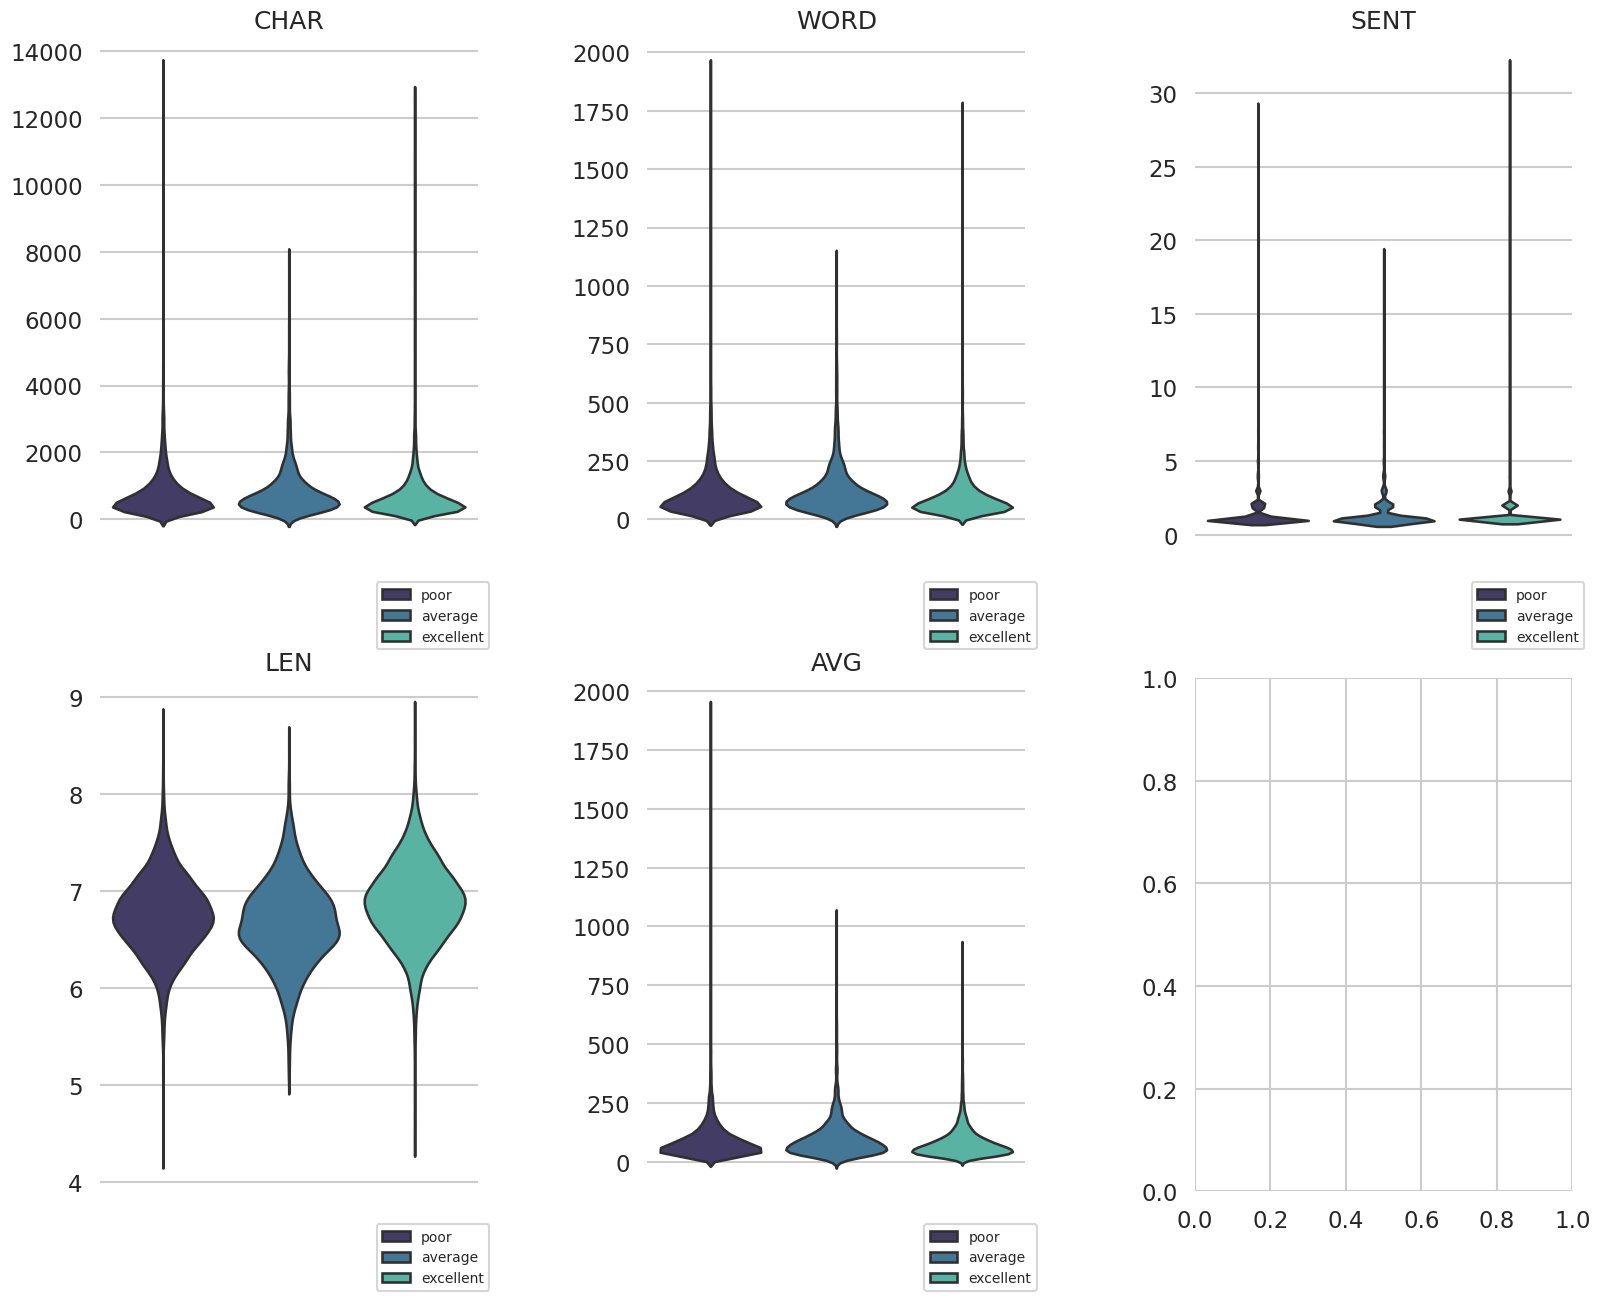

In [34]:
cols = ['TARGET','LEM','CHAR', 'WORD','SENT','LEN','AVG']

# plot feature distributions for helpful and unhelpful reviews
sns.set_style('whitegrid')
sns.set_context("talk")

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(19,15), facecolor='w')
plt.subplots_adjust(wspace=.45, hspace=.25)
sns.despine(bottom = True, left = True)


r = c = 0
for col in cols[2:]:
    sns.violinplot(data=df_eda, y=df_eda[col], x=df_eda.target,
                   ax=ax[r][c],
                   inner=None, palette='mako').set_title(col)

# ax[r][c].set_ylim(ymin=None, ymax=df[col].quantile(.995))
    ax[r][c].set_xticks([])
    ax[r][c].set_xlabel('')
    ax[r][c].set_ylabel('')
    ax[r][c].legend(labels=['poor','average','excellent'], bbox_to_anchor=(1.05, -0.05), prop={'size':10})


    if c < 2:
        c += 1
    else:
        r += 1
        c = 0


# plt.savefig(fname='images/density', bbox_inches='tight', pad_inches=0.1)
plt.show()

#error and how to show legend

Based on this feature to feature correlation heatmap, the character count, word count, and average length of sentence have a high correlation to each other.

# Train Test Split

In [36]:
X = df['tokenized']
y = df['new_rating']

In [37]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .8, random_state= 42)

# Vectorizing

The TF-IDF Vectorizer is utilized, which takes into account how frequent a word appears in a document and also how unqiue the word is in overall corpus. In order to capture the most meaningful words, we cut off the top 20% and bottom 10% of words in the documents.

In [38]:
tfidf_train = TfidfVectorizer(sublinear_tf=True, max_df=.9, min_df=.05,  ngram_range=(1, 1))

In [39]:
train_features = tfidf_train.fit_transform(X_train).toarray()
test_features = tfidf_train.transform(X_test).toarray()

In [44]:
pd.set_option('display.max_rows', None)

wm = tfidf_train.fit_transform(X_train)
tokens = tfidf_train.get_feature_names_out()

wm.shape
doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
data = pd.DataFrame(data=wm.toarray(), index=doc_names,
                  columns=tokens)
data.mean().sort_values()

,0
tried,0.008206
bring,0.008369
lunch,0.008705
table,0.008798
ride,0.008869
fact,0.008912
including,0.009064
ate,0.009106
flight,0.009291
arrival,0.009354


# PCA

We used PCA in order to reduce multidimensionality for some of the models to determine if results would vary.

In [45]:
pca = PCA(n_components=0.9, random_state=1)

pca_train = pca.fit_transform(train_features)
pca_test = pca.transform(test_features)

In [46]:
pca.n_components_

np.int64(241)

**PCA Visual**

In [47]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(train_features)

pca1 = pca_result[:,0]
pca2 = pca_result[:,1]
pca3 = pca_result[:,2]

target = pd.Categorical(y_train).codes

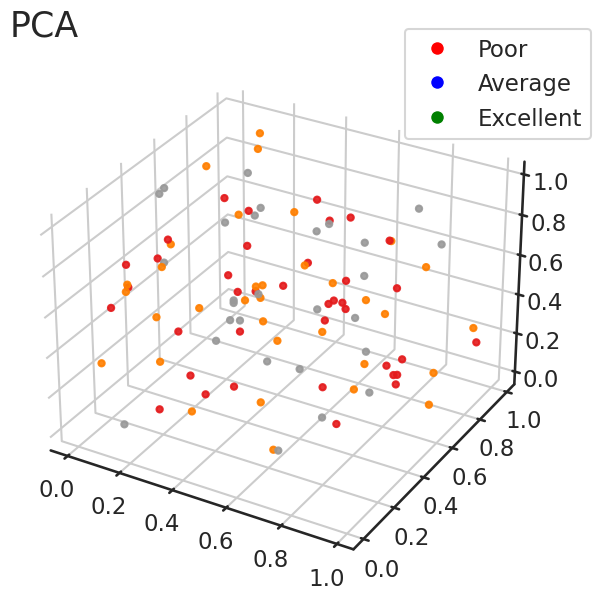

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Sample PCA data
np.random.seed(42)
pca1 = np.random.rand(100)
pca2 = np.random.rand(100)
pca3 = np.random.rand(100)
target = np.random.randint(0, 3, 100)  # Class labels (0, 1, 2)

# Define class labels
labels = {0: "Poor", 1: "Average", 2: "Excellent"}
colors = ['red', 'blue', 'green']

fig = plt.figure(figsize=(19, 7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title('PCA', fontsize=25, loc='left')

# Scatter plot with proper color mapping
scatter = ax.scatter(pca1, pca2, pca3, c=target, cmap=plt.cm.Set1, alpha=0.9)

# Remove background grid lines
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

ax.xaxis.pane.set_alpha(0.0)
ax.yaxis.pane.set_alpha(0.0)
ax.zaxis.pane.set_alpha(0.0)

# Create legend manually
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10,
                      markerfacecolor=colors[i]) for i in labels]

ax.legend(handles, labels.values(), loc="upper right", bbox_to_anchor=(1.1, 1.05))

plt.show()


# Modeling

We fit several different models to evaluate the compare which one outputs the highest accuracy & F1 score. In order to accurately compare each model against one another, we performed a grid-search to determine the optimal hyperparameters for each model.

In [50]:
# create function to call for evaluation of each model

def metrics_score(train_preds, y_train, test_preds, y_test):
    print(f"Training Accuracy:\t{accuracy_score(y_train, train_preds):.4}",
          f"\tTesting Accuracy:\t{accuracy_score(y_test, test_preds):.4}")
    print(f"Training Precision:\t{precision_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Precision:\t{precision_score(y_test, test_preds, average='weighted'):.4}")
    print(f"Training Recall:\t{recall_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Recall:\t\t{recall_score(y_test, test_preds, average='weighted'):.4}")
    print(f"Training F1:\t\t{f1_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting F1:\t\t{f1_score(y_test, test_preds, average='weighted'):.4}")

### **Naive Bayes**

In [51]:
scorer = make_scorer(f1_score, average='weighted')

params=  {'alpha': [0.09, 0.1,0.11]}

nb = MultinomialNB()

grid_search_nb = GridSearchCV(estimator = nb,scoring=scorer, param_grid = params,
                              cv = 5, n_jobs = -1, verbose = 2)

In [52]:
grid_search_nb.fit(train_features, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.09, 0.1, 0.11]},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted),
             verbose=2)

In [53]:
nb_train_preds = grid_search_nb.best_estimator_.predict(train_features)
nb_test_preds = grid_search_nb.best_estimator_.predict(test_features)
metrics_score(nb_train_preds, y_train, nb_test_preds, y_test)

Training Accuracy:	0.644 	Testing Accuracy:	0.6475
Training Precision:	0.6607 	Testing Precision:	0.6643
Training Recall:	0.644 	Testing Recall:		0.6475
Training F1:		0.632 	Testing F1:		0.6322


### **Logisitic Regression**

In [54]:
#scaling data
ss = StandardScaler()
train_scaled = ss.fit_transform(train_features)
test_scaled = ss.transform(test_features)

In [55]:
# Create regularization hyperparameter space
C = np.logspace(0, 1, 10)

params = dict(C=C, max_iter=[50, 100])

logistic = linear_model.LogisticRegression(penalty='l2', class_weight='balanced', random_state=42)

grid_search_LR = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = params,
                              cv = 3, n_jobs = -1, verbose = 2)

In [56]:
grid_search_LR.fit(train_scaled, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ]),
                         'max_iter': [50, 100]},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted),
             verbose=2)

In [57]:
lr_train_preds = grid_search_LR.best_estimator_.predict(train_scaled)
lr_test_preds = grid_search_LR.best_estimator_.predict(test_scaled)
metrics_score(lr_train_preds, y_train, lr_test_preds, y_test)

Training Accuracy:	0.6942 	Testing Accuracy:	0.6831
Training Precision:	0.6986 	Testing Precision:	0.687
Training Recall:	0.6942 	Testing Recall:		0.6831
Training F1:		0.6928 	Testing F1:		0.6807


### **Logisitic Regression with PCA**

In [58]:
# Create regularization hyperparameter space
C = np.logspace(0, 1, 10)

params = dict(C=C, max_iter=[50, 100])

logistic = linear_model.LogisticRegression(penalty='l2', class_weight='balanced', random_state=42)

grid_search_LR_pca = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = params,
                                  cv = 3, n_jobs = -1, verbose = 2)

In [59]:
grid_search_LR_pca.fit(pca_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ]),
                         'max_iter': [50, 100]},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted),
             verbose=2)

In [60]:
lr_train_preds_pca = grid_search_LR_pca.best_estimator_.predict(pca_train)
lr_test_preds_pca = grid_search_LR_pca.best_estimator_.predict(pca_test)
metrics_score(lr_train_preds_pca, y_train, lr_test_preds_pca, y_test)

Training Accuracy:	0.6905 	Testing Accuracy:	0.6872
Training Precision:	0.6953 	Testing Precision:	0.6913
Training Recall:	0.6905 	Testing Recall:		0.6872
Training F1:		0.6892 	Testing F1:		0.6853


### **Decision Tree**

In [61]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

params = dict(criterion=criterion,
                max_depth=max_depth)

DT = tree.DecisionTreeClassifier(criterion =  'gini', max_depth= 10, random_state = 42)

grid_search_DT = GridSearchCV(estimator=DT, param_grid=params, scoring=scorer,
                              cv = 5, n_jobs = -1, verbose = 2)

In [62]:
grid_search_DT.fit(train_features, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted),
             verbose=2)

In [63]:
dt_train_preds = grid_search_DT.best_estimator_.predict(train_features)
dt_test_preds = grid_search_DT.best_estimator_.predict(test_features)
metrics_score(dt_train_preds, y_train, dt_test_preds, y_test)


Training Accuracy:	0.524 	Testing Accuracy:	0.5221
Training Precision:	0.5351 	Testing Precision:	0.5285
Training Recall:	0.524 	Testing Recall:		0.5221
Training F1:		0.5099 	Testing F1:		0.508


### **Decision Tree with PCA**

In [64]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

params = dict(criterion=criterion,
                max_depth=max_depth)

DT = tree.DecisionTreeClassifier(criterion =  'gini', max_depth= 10, random_state = 42)

grid_search_DT_pca = GridSearchCV(estimator=DT, param_grid=params, scoring=scorer,
                                  cv = 5, n_jobs = -1, verbose = 2)

In [65]:
grid_search_DT_pca.fit(pca_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted),
             verbose=2)

In [66]:
dt_train_preds_pca = grid_search_DT_pca.best_estimator_.predict(pca_train)
dt_test_preds_pca = grid_search_DT_pca.best_estimator_.predict(pca_test)
metrics_score(dt_train_preds_pca, y_train, dt_test_preds_pca, y_test)

Training Accuracy:	0.5698 	Testing Accuracy:	0.574
Training Precision:	0.5681 	Testing Precision:	0.5726
Training Recall:	0.5698 	Testing Recall:		0.574
Training F1:		0.5682 	Testing F1:		0.5716


### **Random Forest**

In [67]:
params = {
    'n_estimators': [200, 500],
    'max_features': ['sqrt'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier(random_state = 42)

grid_search_RF = GridSearchCV(estimator=rf, param_grid=params, scoring=scorer,
                              cv = 5, n_jobs = -1, verbose = 2)


In [68]:
grid_search_RF.fit(train_features, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8], 'max_features': ['sqrt'],
                         'n_estimators': [200, 500]},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted),
             verbose=2)

In [69]:
rf_train_preds = grid_search_RF.best_estimator_.predict(train_features)
rf_test_preds = grid_search_RF.best_estimator_.predict(test_features)
metrics_score(rf_train_preds, y_train, rf_test_preds, y_test)

Training Accuracy:	0.586 	Testing Accuracy:	0.5755
Training Precision:	0.6414 	Testing Precision:	0.6422
Training Recall:	0.586 	Testing Recall:		0.5755
Training F1:		0.528 	Testing F1:		0.5172


### **Light GBM**

In [70]:
lgbm = LGBMClassifier(random_state=42)

param_grid = {'n_estimators': [50, 100],
              'colsample_bytree': [0.7, 0.8],
              'max_depth': [15, 20],
              'num_leaves': [50, 100,],
              'min_split_gain': [0.3,0.4],
              'reg_alpha': [1.0, 1.1],
             'objective': ['multiclass'],
             'num_class':[3],
              'class_label':['weight']
             }


grid_lgbm = GridSearchCV(lgbm, param_grid, cv=2, verbose=1, n_jobs=-1)

In [71]:
grid_lgbm.fit(train_features, y_train)

Fitting 2 folds for each of 64 candidates, totalling 128 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: class_label
[LightGBM] [Warning] Unknown parameter: class_label
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 75480
[LightGBM] [Info] Number of data points in the train set: 16392, number of used features: 296
[LightGBM] [Info] Start training from score -0.919009
[LightGBM] [Info] Start training from score -0.813863
[LightGBM] [Info] Start training from score -1.845522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


GridSearchCV(cv=2, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_label': ['weight'],
                         'colsample_bytree': [0.7, 0.8], 'max_depth': [15, 20],
                         'min_split_gain': [0.3, 0.4],
                         'n_estimators': [50, 100], 'num_class': [3],
                         'num_leaves': [50, 100], 'objective': ['multiclass'],
                         'reg_alpha': [1.0, 1.1]},
             verbose=1)

In [72]:
gbm_train_preds = grid_lgbm.best_estimator_.predict(train_features)
gbm_test_preds = grid_lgbm.best_estimator_.predict(test_features)
metrics_score(gbm_train_preds, y_train, gbm_test_preds, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: class_label


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: class_label
Training Accuracy:	0.9068 	Testing Accuracy:	0.6875
Training Precision:	0.907 	Testing Precision:	0.6882
Training Recall:	0.9068 	Testing Recall:		0.6875
Training F1:		0.9067 	Testing F1:		0.6864
